# Определение перспективного тарифа для телеком компании

Требуется провести предварительный анализ двух тарифных планов на небольшой выборке клиентов. По результатам данного анализа коммерческий департамент скорректирует рекламный бюджет для активного продвижения более выгодного тарифа.

В нашем распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф ("Смарт" или "Ультра") приносит больше денег.

### **Описание тарифов**

*Тариф «Смарт»*

* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей

*Тариф «Ультра»*

* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей
    
*Оператор всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### **Описание данных**

*Таблица users (информация о пользователях):*

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

*Таблица calls (информация о звонках):*

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

*Таблица messages (информация о сообщениях):*

* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

*Таблица internet (информация об интернет-сессиях):*

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

*Таблица tariffs (информация о тарифах):*

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats as st
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None


In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

## Обзор данных




### 1.1. Пользователи (users)

In [3]:
# данные о пользователях
display(users.head())
print(users.info())
print('\nПропущенные значения:')
print(users.isnull().sum())
display(users.describe())
print('\nДубликаты:', users.duplicated().sum())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

Пропущенные значения:
user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000



Дубликаты: 0


Пропуски есть только в **churn_date** (дата прекращения пользования тарифом), что говорит об активности данного тарифа на момент выгрузки. Дубликатов нет.

Нужно привести поле с датой подключения тарифа **reg_date** к типу datetime.


### 1.2. Звонки (calls)

In [4]:
# данные о звонках
display(calls.head())
print(calls.info())
display(calls.describe())
print('\nДубликаты:', calls.duplicated().sum())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000



Дубликаты: 0


In [5]:
# Посмотрим на записи с продолжительностью звонка в ноль минут:
print('Количество записей с нулевой продолжительностью звонка:', calls.query('duration == 0')['user_id'].count())
print('Доля звонков с нулевой продолжительностью: {:.0%}'.format(calls.query('duration == 0')['user_id'].count() / len(calls)))
display(calls[['user_id', 'duration']].query('duration == 0').groupby('user_id').agg('count')['duration'].describe())


Количество записей с нулевой продолжительностью звонка: 39613
Доля звонков с нулевой продолжительностью: 20%


count    492.000000
mean      80.514228
std       57.484309
min        5.000000
25%       35.750000
50%       66.000000
75%      114.000000
max      336.000000
Name: duration, dtype: float64

* Практически по каждому пользователю (кроме 8 из 500) есть звонки с нулевой продолжительностью **duration**. В среднем - 66 на клиента. Всего по базе - 39613, или 20%. Данные звонки никак не влияют на выручку пользователей, т.к. их стоимость равна нулю. К тому же они искажают данные о средней продолжительности разговора. Такие записи стоит удалить - будем считать только состоявшиеся разговоры.
* Также нужно будет привести поле **call_date** к типу datetime.

### 1.3. Интернет (internet)


In [6]:
# данные об интернет-сессиях
display(internet.head(10))
print(internet.info())
display(internet['mb_used'].describe())
print('Дубликаты:', internet.duplicated().sum())

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Дубликаты: 0


In [7]:
# Рассмотрим нулевые сессии:
print('Количество нулевых сессий:', internet.query('mb_used == 0')['id'].count())
print('Доля нулевых сессий: {:.0%}'.format(internet.query('mb_used == 0')['id'].count() / len(internet)))

Количество нулевых сессий: 19598
Доля нулевых сессий: 13%


* В базе содержится 19.5 тысяч (13%) записей с нулевой продолжительностью сессии **mb_used**. Такие транзакции не влияют на выручку по клиенту, однако, искажают данные о средней продолжительности ненулевой сессии - исключим их из рассмотрения.
* Поле **session_date** нужно привести к типу datetime.
* Поле **Unnamed**: 0 нужно удалить.

### 1.4. Сообщения (messages)

In [8]:
# данные о сообщениях 
display(messages.head(10))
print(messages.info())
print('Дубликаты:', messages.duplicated().sum())

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
Дубликаты: 0


На первый взгляд всё прилично, кроме типа поля message_date - нужно привести к datetime.

### 1.5. Тарифы (tariffs)

In [9]:
# информация о тарифах 
display(tariffs)
print(tariffs.info())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


Все поля заполнены. Проблем с типами данных нет.

### **Обзор данных. Выводы**
Просмотрели все таблицы, зафиксировали проблемные места.

**Исправить типы данных:**

* привести поле users[reg_date] к типу datetime.
* привести поле calls[call_date] к типу datetime.
* привести поле internet[session_date] к типу datetime.
* привести поле messages[message_date] к типу datetime.

**Проблемы в данных:**

* Практически по каждому пользователю (кроме 8 из 500) есть звонки с нулевой продолжительностью calls[duration]. В среднем - 66 на клиента. Всего по базе - 39613, или 20%. Данные звонки никак не влияют на выручку пользователей, т.к. их стоимость равна нулю. К тому же они искажают данные о средней продолжительности разговора. Такие записи стоит удалить - будем считать только состоявшиеся разговоры.
* В базе содержится 19.5 тысяч (13%) записей с нулевой продолжительностью сессии internet[mb_used]. Такие транзакции не влияют на выручку по клиенту, однако, искажают данные о средней продолжительности ненулевой сессии - исключим их из рассмотрения.

# 2. Предобработка данных. Приведение типов. Исправление ошибок

In [10]:
# Обработаем данные по пользователям (users)
# Изменим тип данных поля 'reg_date' на datetime:
try:
  users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
except:
  print('Проверьте корректность данных в столбце "reg_date"')  

display(users.sample(5))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
163,1163,21,2018-12-16,Москва,Лев,Вишневский,2018-11-03,smart
207,1207,57,NaN,Балашиха,Яна,Зеленина,2018-08-12,smart
486,1486,35,NaN,Нижний Новгород,Матвей,Моргунов,2018-10-31,smart
388,1388,24,NaN,Вологда,Рустам,Левин,2018-08-27,smart
160,1160,73,NaN,Ульяновск,Борис,Авдонюшкин,2018-07-03,smart


In [11]:
# Обработаем записи о звонках (calls)
# Удалим записи с нулевой продолжительностью
print('Количество записей до удаления:', len(calls)) # 202607
calls = calls.loc[calls['duration'] != 0]
print('Количество записей после удаления:', len(calls))

# Изменим тип данных поля 'call_date' на datetime:
try:
    calls['call_date']= pd.to_datetime(calls['call_date'], format='%Y-%m-%d') # 2018-07-25
except:
    print('Проверьте корректность данных в столбце "call_date"')    

display(calls.sample(5))

Количество записей до удаления: 202607
Количество записей после удаления: 162994


,id,call_date,duration,user_id
48663,1121_320,2018-11-19,10.48,1121
83620,1208_472,2018-10-09,7.01,1208
172834,1427_198,2018-08-26,3.06,1427
12312,1032_331,2018-04-27,2.23,1032
60404,1152_101,2018-03-30,7.13,1152


In [12]:
# Обработаем записи о сессиях в интернете (internet)
# Исключим из рассмотрения сессии с нулевой продолжительностью:
print('Количество записей до удаления:', len(internet)) # 149396
internet = internet.loc[internet['mb_used'] != 0]
print('Количество записей после удаления:', len(internet)) # 129798  

# Изменим тип данных поля 'session_date' на datetime:
try:
    internet['session_date']= pd.to_datetime(internet['session_date'], format='%Y-%m-%d') # 2018-11-25
except:
    print('Проверьте корректность данных в столбце "session_date"')    

display(internet.sample(5))
#print(internet.info())

Количество записей до удаления: 149396
Количество записей после удаления: 129798


,Unnamed: 0,id,mb_used,session_date,user_id
10436,10436,1035_271,131.61,2018-06-24,1035
23344,23344,1078_261,510.41,2018-12-04,1078
146020,146020,1489_29,425.14,2018-09-09,1489
24119,24119,1082_106,540.70,2018-10-09,1082
107779,107779,1366_134,44.70,2018-12-22,1366


In [13]:
# Обработаем данные о сообщениях (messages)
# Изменим тип данных поля 'message_date' на datetime:
try:
    messages['message_date']= pd.to_datetime(messages['message_date'], format='%Y-%m-%d') # 2018-06-27
except:
    print('Проверьте корректность данных в столбце "message_date"') 
    
display(messages.sample(5))
print(messages.info())

,id,message_date,user_id
252,1000_252,2018-10-19,1000
65694,1282_126,2018-02-23,1282
72131,1303_83,2018-09-27,1303
63791,1277_468,2018-04-15,1277
25491,1104_683,2018-12-04,1104


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB
None


## Предобработка данных. Выводы¶
### **Исправили типы данных:**

* привели поле users[reg_date] к типу datetime.
* привели поле calls[call_date] к типу datetime.
* привели поле internet[session_date] к типу datetime.
* привели поле messages[message_date] к типу datetime.

**Устранили проблемы в данных:**

* Удалили из выборки звонки с нулевой продолжительностью calls[duration].
* Удалили из выборки нулевые интренет-сессии internet[mb_used].

# 3. Рассчёт показателей по клиентам 

Прежде всего, подготовим датафрейм, куда мы будем собирать помесячную статистику для каждого пользователя. Даже для тех, кто не совершал звонков / не отправлял сообщений / не выходил в интернет, а также для тех, кто делал это не каждый месяц.

In [14]:
# Сформируем полный список месяцев для нашего отчёта:
month = pd.DataFrame(pd.date_range(calls['call_date'].min(), calls['call_date'].max(), freq='MS'))
month.columns = ['month']
display(month) # Проверим глазами

# Соединим этот список со списком пользователей:
users['key'] = 1
month['key'] = 1
report = month.merge(users, on='key')
# Удалим ненеужное теперь поле 'key':
report.drop('key', axis=1, inplace=True)

#print(len(report), "???", len(month) * len(users)) # 6000 = 6000 / ничего не потеряли

# Удалим лишние месяцы по пользователям, зарегистрировавшимся в течении 2018 года:
report = report[report['month'] >= report['reg_date'].astype('datetime64[M]')]
display(report.sort_values(['user_id', 'month']).head(15)) # Проверим глазами

# Оставим только нужные для отчёта поля:
report = report[['user_id', 'month', 'tariff', 'churn_date', 'city']]
display(report.head())
display(report.info())

,month
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
5,2018-06-01
6,2018-07-01
7,2018-08-01
8,2018-09-01
9,2018-10-01


,month,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
2000,2018-05-01,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2500,2018-06-01,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3000,2018-07-01,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3500,2018-08-01,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4000,2018-09-01,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4500,2018-10-01,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5000,2018-11-01,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5500,2018-12-01,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5001,2018-11-01,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
5501,2018-12-01,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart


,user_id,month,tariff,churn_date,city
5,1005,2018-01-01,smart,NaN,Набережные Челны
32,1032,2018-01-01,smart,NaN,Ульяновск
45,1045,2018-01-01,smart,NaN,Улан-Удэ
55,1055,2018-01-01,smart,NaN,Казань
71,1071,2018-01-01,smart,2018-08-31,Омск


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3259 entries, 5 to 5999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     3259 non-null   int64         
 1   month       3259 non-null   datetime64[ns]
 2   tariff      3259 non-null   object        
 3   churn_date  232 non-null    object        
 4   city        3259 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 152.8+ KB


None

Подготовили шаблон для отслеживания ежемесячной активности каждого пользователей. Всего получилось 3259 записей.

### 3.1. Количество звонков и минут разговора по месяцам

In [15]:
# Добавим в таблицу 'calls' столбец для группировки данных по месяцам:
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

# Добавим в таблицу 'calls' поле с округлённым в бОльшую сторону количеством минут:
calls['minutes'] = calls['duration'].apply(lambda x: math.ceil(x))

display(calls.sample(5))

# Посчитаем для каждого пользователя количество звонков и минут разговора по месяцам:
calls_month = calls[['user_id', 'month', 'minutes']].groupby(['user_id', 'month']).agg(['count', 'sum']).reset_index()
calls_month.columns = ['user_id', 'month', 'calls_count', 'calls_duration']
display(calls_month.head(5))
#print(calls['minutes'].sum(), calls_month['calls_duration'].sum()) # 1450301 = 1450301 / ничего не потеряли
#print(len(calls_month['user_id'].unique())) # 492 - не все пользователи разговаривали по телефону в рассматриваемый период

,id,call_date,duration,user_id,month,minutes
188745,1465_462,2018-09-11,12.50,1465,2018-09-01,13
1308,1004_81,2018-07-02,13.46,1004,2018-07-01,14
24388,1062_0,2018-11-26,4.30,1062,2018-11-01,5
45188,1113_604,2018-04-04,4.62,1113,2018-04-01,5
146896,1374_330,2018-09-21,19.10,1374,2018-09-01,20


,user_id,month,calls_count,calls_duration
0,1000,2018-05-01,17,159
1,1000,2018-06-01,28,172
2,1000,2018-07-01,41,340
3,1000,2018-08-01,42,408
4,1000,2018-09-01,46,466



Добавим данные из получившейся таблицы в подготовленный ранее шаблон.

In [16]:
report = report.merge(calls_month, how='left', on=['month', 'user_id'])
display(report.head(15))

,user_id,month,tariff,churn_date,city,calls_count,calls_duration
0,1005,2018-01-01,smart,NaN,Набережные Челны,11.0,95.0
1,1032,2018-01-01,smart,NaN,Ульяновск,44.0,380.0
2,1045,2018-01-01,smart,NaN,Улан-Удэ,1.0,9.0
3,1055,2018-01-01,smart,NaN,Казань,47.0,551.0
4,1071,2018-01-01,smart,2018-08-31,Омск,18.0,194.0
5,1113,2018-01-01,smart,NaN,Чита,13.0,110.0
6,1120,2018-01-01,ultra,NaN,Краснодар,4.0,55.0
7,1126,2018-01-01,ultra,NaN,Санкт-Петербург,28.0,272.0
8,1134,2018-01-01,smart,NaN,Красноярск,33.0,332.0
9,1135,2018-01-01,smart,NaN,Архангельск,9.0,90.0


Составили табличку с данными о количестве состоявшихся звонков и количестве потраченных минут разговора по месяцам для каждого пользователя. Всего получилось 492 пользователя. Остальные 8, возможно, не совершали звонков за рассматриваемый период, либо их звонки оказались "несостоявшимися", т.е. с нулевой продолжительностью и поэтому они в отчёт не попали.

Добавили данные в общий отчёт.

### 3.2. Количество отправленных сообщений по месяцам

In [17]:
# Добавим в таблицу 'messages' столбец для группировки данных по месяцам:
messages['month'] = messages['message_date'].values.astype('datetime64[M]')
display(messages.head(5))

# Посчитаем для каждого пользователя количество отправленных сообщений по месяцам:
messages_month = messages[['user_id', 'month', 'message_date']].groupby(['user_id', 'month']).agg(['count']).reset_index()
messages_month.columns = ['user_id', 'month', 'mess_count']
display(messages_month.head(10))

#print(len(messages), messages_month['mess_count'].sum()) # 123036 = 123036 / ничего не потеряли
#print(len(messages_month['user_id'].unique())) # 426 - не все пользователи отправляли сообщения в рассматриваемый период

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


,user_id,month,mess_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
5,1000,2018-10-01,73
6,1000,2018-11-01,58
7,1000,2018-12-01,70
8,1002,2018-06-01,4
9,1002,2018-07-01,11


Добавим данные из получившейся сводной таблицы в общий отчёт.



In [18]:
report = report.merge(messages_month, how='left', on=['user_id','month'])
display(report.head(15))

,user_id,month,tariff,churn_date,city,calls_count,calls_duration,mess_count
0,1005,2018-01-01,smart,NaN,Набережные Челны,11.0,95.0,7.0
1,1032,2018-01-01,smart,NaN,Ульяновск,44.0,380.0,38.0
2,1045,2018-01-01,smart,NaN,Улан-Удэ,1.0,9.0,5.0
3,1055,2018-01-01,smart,NaN,Казань,47.0,551.0,30.0
4,1071,2018-01-01,smart,2018-08-31,Омск,18.0,194.0,16.0
5,1113,2018-01-01,smart,NaN,Чита,13.0,110.0,14.0
6,1120,2018-01-01,ultra,NaN,Краснодар,4.0,55.0,NaN
7,1126,2018-01-01,ultra,NaN,Санкт-Петербург,28.0,272.0,4.0
8,1134,2018-01-01,smart,NaN,Красноярск,33.0,332.0,32.0
9,1135,2018-01-01,smart,NaN,Архангельск,9.0,90.0,1.0


Составили табличку с данными о количестве отправленных сообщений по месяцам для каждого пользователя. Всего получилось 426 пользователей. Остальные, вероятно, предпочитают сообщениям звонки и/или переписку по интернету.

Добавили данные в общий отчёт.


## 3.3. Объём израсходованного интернет-трафика по месяцам

In [19]:
# Добавим в таблицу 'internet' столбец для группировки данных по месяцам:
internet['month'] = internet['session_date'].values.astype('datetime64[M]')
display(internet.head())

# Добавим в таблицу поле с округлённым в большую сторону количеством минут:
internet['megabytes'] = internet['mb_used'].apply(lambda x: math.ceil(x))
display(internet.sample(5))

# Посчитаем для каждого пользователя объём трафика по месяцам:
internet_month = internet[['user_id', 'month', 'megabytes']].groupby(['user_id', 'month']).agg(['sum']).reset_index()
internet_month.columns = ['user_id', 'month', 'megabytes']
display(internet_month.sample(5))
#print(internet['megabytes'].sum(), '???', internet_month['megabytes'].sum()) # 55369459 = 55369459 / ничего не потеряли
#print(len(internet_month['user_id'].unique())) # 497 - почти все пользователи пользовались интернетом в рассматриваемый период

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,2018-11-01
1,1,1000_1,1052.81,2018-09-07,1000,2018-09-01
2,2,1000_2,1197.26,2018-06-25,1000,2018-06-01
3,3,1000_3,550.27,2018-08-22,1000,2018-08-01
4,4,1000_4,302.56,2018-09-24,1000,2018-09-01


,Unnamed: 0,id,mb_used,session_date,user_id,month,megabytes
114987,114987,1388_4,582.90,2018-12-05,1388,2018-12-01,583
55267,55267,1185_389,596.47,2018-09-09,1185,2018-09-01,597
100734,100734,1338_124,686.00,2018-08-13,1338,2018-08-01,686
76064,76064,1255_260,427.61,2018-03-23,1255,2018-03-01,428
28497,28497,1099_161,828.84,2018-11-25,1099,2018-11-01,829


,user_id,month,megabytes
1824,1290,2018-07-01,18544
1120,1176,2018-02-01,13736
2814,1437,2018-10-01,18498
2691,1421,2018-12-01,14625
96,1012,2018-11-01,22546


Добавим данные из получившейся таблицы в общий отчёт.



In [20]:
report = report.merge(internet_month, how='left', on=['month', 'user_id'])
display(report.head(15))

,user_id,month,tariff,churn_date,city,calls_count,calls_duration,mess_count,megabytes
0,1005,2018-01-01,smart,NaN,Набережные Челны,11.0,95.0,7.0,2730.0
1,1032,2018-01-01,smart,NaN,Ульяновск,44.0,380.0,38.0,24147.0
2,1045,2018-01-01,smart,NaN,Улан-Удэ,1.0,9.0,5.0,2348.0
3,1055,2018-01-01,smart,NaN,Казань,47.0,551.0,30.0,17111.0
4,1071,2018-01-01,smart,2018-08-31,Омск,18.0,194.0,16.0,15622.0
5,1113,2018-01-01,smart,NaN,Чита,13.0,110.0,14.0,767.0
6,1120,2018-01-01,ultra,NaN,Краснодар,4.0,55.0,NaN,657.0
7,1126,2018-01-01,ultra,NaN,Санкт-Петербург,28.0,272.0,4.0,16377.0
8,1134,2018-01-01,smart,NaN,Красноярск,33.0,332.0,32.0,10215.0
9,1135,2018-01-01,smart,NaN,Архангельск,9.0,90.0,1.0,1601.0



Составили табличку с данными об объёме интернет-трафика по месяцам для каждого пользователя. Всего получилось 497 пользователей. Почти все.

Добавили данные в общий отчёт.

## 3.4. Помесячная выручка с каждого пользователя

In [26]:
# Записи с нулевой активностью
report.sort_values(by=['user_id', 'month'], inplace=True)
display(report[report['calls_count'].isna() & report['mess_count'].isna() & report['megabytes'].isna()].sort_values(['user_id', 'month']))
#print(len(report[report['calls_count'].isna() & report['mess_count'].isna() & report['megabytes'].isna()].sort_values(['user_id', 'month']))) # 45)


,user_id,month,tariff,churn_date,city,calls_count,calls_duration,mess_count,megabytes
2313,1019,2018-11-01,ultra,2018-10-05,Томск,NaN,NaN,NaN,NaN
2778,1019,2018-12-01,ultra,2018-10-05,Томск,NaN,NaN,NaN,NaN
2793,1034,2018-12-01,smart,2018-11-21,Вологда,NaN,NaN,NaN,NaN
2343,1050,2018-11-01,ultra,2018-10-03,Тюмень,NaN,NaN,NaN,NaN
2809,1050,2018-12-01,ultra,2018-10-03,Тюмень,NaN,NaN,NaN,NaN
2344,1051,2018-11-01,smart,2018-10-14,Москва,NaN,NaN,NaN,NaN
2810,1051,2018-12-01,smart,2018-10-14,Москва,NaN,NaN,NaN,NaN
2349,1056,2018-11-01,smart,2018-10-14,Иркутск,NaN,NaN,NaN,NaN
2815,1056,2018-12-01,smart,2018-10-14,Иркутск,NaN,NaN,NaN,NaN
1547,1071,2018-09-01,smart,2018-08-31,Омск,NaN,NaN,NaN,NaN


Все эти записи вырожденные - информации по ним быть не может, т.к. пользователь прекратил пользоваться тарифом раньше времени, на которое строится отчёт (churn_date < month). Удалим их.

In [28]:
print('Количество записей до удаления:', len(report)) #3259
report = report[~(report['calls_count'].isna() & report['mess_count'].isna() & report['megabytes'].isna())]
print('Количество записей после удаления:', len(report)) # 3214 / 3259 - 3214 = 45 / ничего лишнего не удалили

Количество записей до удаления: 3259
Количество записей после удаления: 3214


Теперь заменим все получившиеся пропуски в количестве звонков/минутах/сообщениях/трафике на нули и заменим тип данных на int.

In [30]:
display('До замены NaN и приведения типов:', report.isna().sum())

report['calls_count'] = report['calls_count'].fillna(0).astype('int')
report['calls_duration'] = report['calls_duration'].fillna(0).astype('int64')
report['mess_count'] = report['mess_count'].fillna(0).astype('int64')
report['megabytes'] = report['megabytes'].fillna(0).astype('int64')

display('После замены NaN и приведения типов:', report.isna().sum())

'До замены NaN и приведения типов:'

user_id              0
month                0
tariff               0
churn_date        3027
city                 0
calls_count         46
calls_duration      46
mess_count         497
megabytes           13
dtype: int64

'После замены NaN и приведения типов:'

user_id              0
month                0
tariff               0
churn_date        3027
city                 0
calls_count          0
calls_duration       0
mess_count           0
megabytes            0
dtype: int64

Вычислим ежемесячную выручку по каждому клиенту из нашей выборки.

In [31]:
"""
Функция принимает на вход строку отчёта (помесячная активность каждого клиента) и вычисляет для неё выручку.
"""

def revenue(row):
  tariff = tariffs[tariffs['tariff_name'] == row['tariff']] # тариф, которым пользуется клиент
  paid_minutes = 0
  paid_mess = 0 
  paid_mb = 0
  
  if row['calls_duration'] != 0: # если клиент в этом месяце разговаривал по телефону
    paid_minutes = max(0, float(row['calls_duration'] - tariff['minutes_included'].values)) # вычисляем кол-во платных минут )
  if row['mess_count'] != 0: # если клиент отправлял в этом месяце сообщения
        paid_mess = max(0, float(row['mess_count'] - tariff['messages_included'].values)) # вычисляем кол-во платных сообщений
  if row['megabytes'] != 0: # если клиент в этом месяце пользовался интернетом
        paid_mb = max(0, float(row['megabytes'] - tariff['mb_per_month_included'].values)) # вычисляем платный трафик (Мб)
    
  # считаем выручку:
  revenue = (paid_minutes * tariff['rub_per_minute'].values + # платные минуты * цена минуты
               paid_mess * tariff['rub_per_message'].values + # платные сообщения * цена сообщения
               (paid_mb / 1024) * tariff['rub_per_gb'].values + # платные Гб * цена Гб
               tariff['rub_monthly_fee'].values # абонентская плата
              )
  return round(float(revenue), 2)  

In [32]:
report['revenue'] = report.apply(revenue, axis=1)
display(report.head(10))

,user_id,month,tariff,churn_date,city,calls_count,calls_duration,mess_count,megabytes,revenue
406,1000,2018-05-01,ultra,NaN,Краснодар,17,159,22,2256,1950.00
614,1000,2018-06-01,ultra,NaN,Краснодар,28,172,60,23257,1950.00
862,1000,2018-07-01,ultra,NaN,Краснодар,41,340,75,14016,1950.00
1154,1000,2018-08-01,ultra,NaN,Краснодар,42,408,81,14070,1950.00
1496,1000,2018-09-01,ultra,NaN,Краснодар,46,466,57,14581,1950.00
1873,1000,2018-10-01,ultra,NaN,Краснодар,44,350,73,14717,1950.00
2295,1000,2018-11-01,ultra,NaN,Краснодар,37,338,58,14768,1950.00
2759,1000,2018-12-01,ultra,NaN,Краснодар,38,333,70,9827,1950.00
2296,1001,2018-11-01,smart,NaN,Москва,45,430,0,18452,1153.91
2760,1001,2018-12-01,smart,NaN,Москва,47,414,0,14053,550.00


Составили отчёт о ежемесячной активности пользователей обоих тарифных планов. Посчитали ежемесячную выручку с каждого клиента.

# 4. Исследовательский анализ данных

Опишем поведение клиентов, исходя из выборки. Для этого построим гистограммы и рассмотрим распределения переменных нашего отчёта.

In [33]:
def hist_display(df, param, title):
# Функция строит гистограмму для переменной 'param' датафрейма 'df' с заголовком 'title' - 
# отдельно для каждого тарифа (smart и ultra), и, для удобства сравнения, на одном графике
    d = df[param].describe()
    r1 = d['25%'] - 3 * (d['75%'] - d['25%'])
    r2 = d['25%'] + 5 * (d['75%'] - d['25%'])
    if r1 < 0: r1 = 0 # Отрицательных значений у нас нет
    df.query('tariff=="smart"')[param].plot(kind='hist', x=param, y='Частота', bins=30, range=(r1, r2), grid=True, title=title, figsize=(10,5), legend=True, alpha=0.5, color='g', label='smart') 
    df.query('tariff=="ultra"')[param].plot(kind='hist', x=param, y='Частота', bins=30, range=(r1, r2), grid=True, title=title, figsize=(10,5), legend=True, alpha=0.5, color='r', label='ultra')

In [36]:
def distplot_display(df, param, title):
# Функция строит график распределения для параметра 'param' датафрейма 'df' для каждого тарифного плана (smart и ultra), 
# а также выводит описание describe() колонки df[param] и считает дисперсию 'param'
    df_dropna = df.dropna(subset=[param])
    df_smart = df_dropna.query('tariff=="smart"')
    df_ultra = df_dropna.query('tariff=="ultra"')
    plt.figure(figsize=(8,5))
    plt.title(title)
    plt.ylabel('Плотность')
    sns.distplot(df_smart[param], color='g', label='smart')
    sns.distplot(df_ultra[param], color='r', label='ultra')
    plt.legend()
    plt.show()
    
    smart_descr = df_smart[param].describe()
    ultra_descr = df_ultra[param].describe()
    smart_disp = np.var(df_smart[param], ddof=1)
    ultra_disp = np.var(df_ultra[param], ddof=1)
    
    df_describe = pd.concat([smart_descr, ultra_descr], axis=1)
    df_describe.columns = ['smart', 'ultra']
    df_describe.loc['dispersion'] = [smart_disp, ultra_disp]

    display(df_describe)

Взглянем на общее количество пользователей тарифов Smart и Ultra и их показатели:



In [37]:
user_report = (report.groupby(['user_id', 'tariff'])
                   .agg(
                       calls_count = ('calls_count','sum'),
                       calls_duration = ('calls_duration','sum'),
                       mess_count = ('mess_count','sum'),
                       traffic = ('megabytes','sum'),     
                       revenue = ('revenue','sum'))
                   .reset_index()
              )

tariff_report = (user_report.groupby('tariff')
                    .agg(
                        users = ('tariff', 'count'),
                        calls_count = ('calls_count','sum'),
                        calls_duration = ('calls_duration','sum'),
                        mess_cout = ('mess_count','sum'),
                        traffic = ('traffic','sum'),     
                        revenue = ('revenue','sum'))
                    .reset_index()
                )
display(tariff_report)
#display(user_report.sample(5))
#print(report['revenue'].sum()) # 4778757.89 = 2749135.84 + 2029622.05 / ничего не потеряли
#print(calls['minutes'].sum()) # 1450301 = 931577.0 + 518724.0

,tariff,users,calls_count,calls_duration,mess_cout,traffic,revenue
0,smart,350,104646,931577,74413,36174861,2749135.84
1,ultra,148,58348,518724,48623,19194598,2029622.05


Меньше трети клиентов из нашей выборки пользуются тарифом Ultra, остальным подключен Smart. При этом более 40% выручки пришлось на пользователей Ultra. Пропорции по остальным параметрам сохраняют ту же тенденцию - пользователи Ultra в среднем потребляют больше ресурсов - дольше разговаривают, пишут больше sms и используют больше трафика.

Рассмотрим каждый параметр по отдельности.

## 4.1. Количество звонков.

Рассмотрим частотную гистограмму и распределение ежемесячного количества звонков по каждому тарифному плану.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


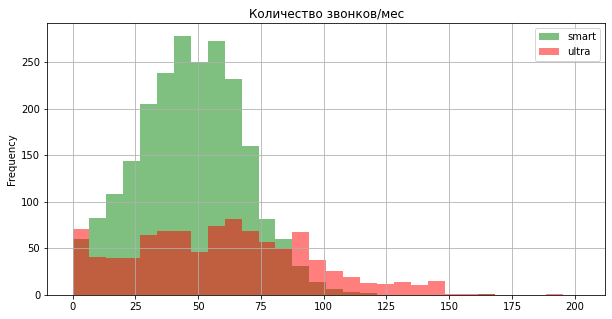

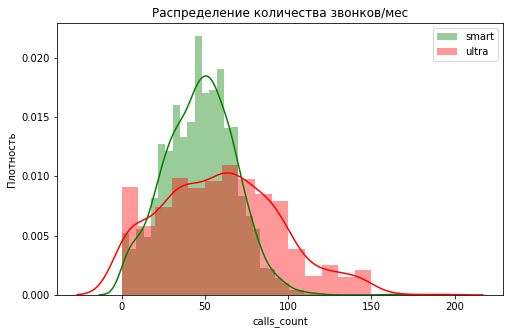

,smart,ultra
count,2229.000000,985.000000
mean,46.947510,59.236548
std,21.039171,35.562722
min,0.000000,0.000000
25%,32.000000,33.000000
50%,47.000000,58.000000
75%,61.000000,84.000000
max,162.000000,190.000000
dispersion,442.646705,1264.707199


In [38]:
hist_display(report, 'calls_count', 'Количество звонков/мес')
distplot_display(report, 'calls_count', 'Распределение количества звонков/мес')

* Общее количество звонков пользователей тарифа Smart почти в 2.3 раза больше, чем у пользователей Ultra - это следствие неравномерного распространения тарифов в нашей выборке.
* Распределения по обоим тарифам тяготеют к нормальному и скошены вправо. Для тарифа Ultra оно ещё и шире - значит, разброс количества звонков в месяц у пользователей данного тарифа сильно варьируется (о том же говорит и большая дисперсия).
* Среднее количество звонков/мес пользователей Ultra больше, чем у пользователей Smart (59 > 47).
* Медианы для обоих тарифных планов почти совпадают со средними значениями. Значит, выбросов в выборке немного.

## 4.2. Продолжительность разговора.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


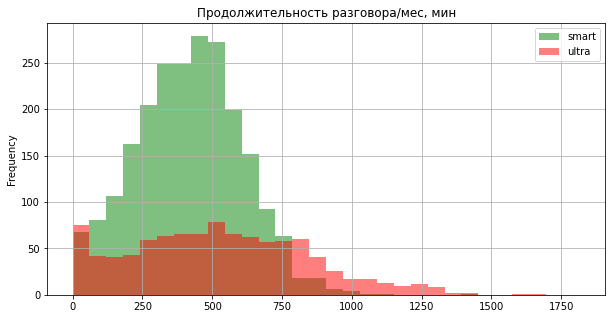

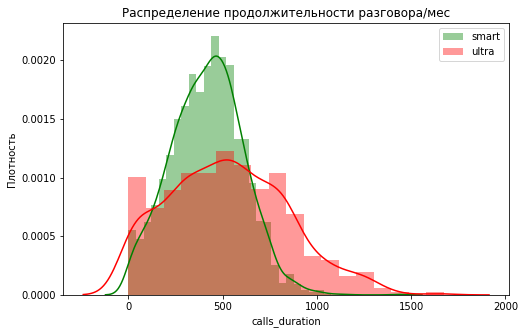

,smart,ultra
count,2229.000000,985.000000
mean,417.934948,526.623350
std,190.313730,317.606098
min,0.000000,0.000000
25%,282.000000,284.000000
50%,422.000000,518.000000
75%,545.000000,752.000000
max,1435.000000,1673.000000
dispersion,36219.315784,100873.633397


In [39]:
hist_display(report, 'calls_duration', 'Продолжительность разговора/мес, мин')
distplot_display(report, 'calls_duration', 'Распределение продолжительности разговора/мес')

* Частотные гистограммы и графики распределения схожи с предыдущими. Распределение продолжительности звонков пользователей Ultra шире, чем у Smart. Значит, и разброс значений по Smart больше. Это подтвержается внушительной дисперсией и, соответственно, большим стандартным отклонением.
* Пользователи Ultra ежемесячно в среднем дольше говорят по телефону, чем пользователи Smart (527 против 418 минут).
* Медианы по обоим тарифным планам примерно совпадают со средними значениями, значит, выбросов немного.

## 4.3. Количество сообщений.

Рассмотрим гистограмму и распределение ежемесячного количества sms абонентов на разных тарифах.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


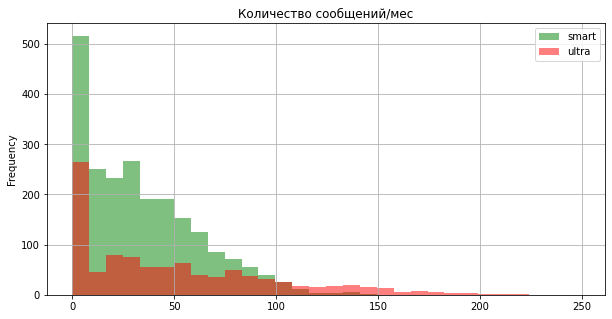

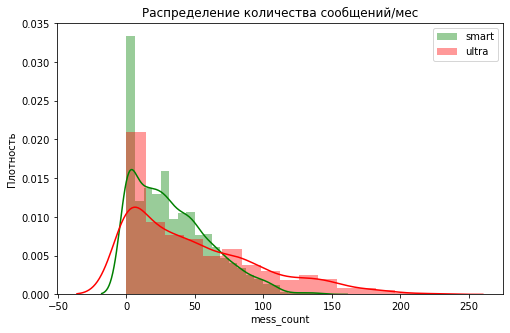

,smart,ultra
count,2229.000000,985.000000
mean,33.384029,49.363452
std,28.227876,47.804457
min,0.000000,0.000000
25%,10.000000,6.000000
50%,28.000000,38.000000
75%,51.000000,79.000000
max,143.000000,224.000000
dispersion,796.812958,2285.266143


Доля записей с нулевым количеством sms (Ultra): 19.29%
Доля записей с нулевым количеством sms (Smart): 13.77%

Доля клиентов с нулевым количеством sms (Ultra): 16.22%
Доля клиентов с нулевым количеством sms (Smart): 13.71%


In [40]:
hist_display(report, 'mess_count', 'Количество сообщений/мес')
distplot_display(report, 'mess_count', 'Распределение количества сообщений/мес')

print('Доля записей с нулевым количеством sms (Ultra): {:.2%}'
      .format(len(report.query('mess_count == 0 & tariff == "ultra"')) / len(report.query('tariff == "ultra"'))))
print('Доля записей с нулевым количеством sms (Smart): {:.2%}'
      .format(len(report.query('mess_count == 0 & tariff == "smart"')) / len(report.query('tariff == "smart"'))))
print()
print('Доля клиентов с нулевым количеством sms (Ultra): {:.2%}'
      .format(len(user_report.query('mess_count == 0 & tariff=="ultra"')) / len(user_report.query('tariff=="ultra"'))))
print('Доля клиентов с нулевым количеством sms (Smart): {:.2%}'
      .format(len(user_report.query('mess_count == 0 & tariff=="smart"')) / len(user_report.query('tariff=="smart"'))))

* Тенденция сохраняется. Пользователи тарифа Ultra в среднем отправляют больше sms в месяц, чем пользователи тарифа Smart (49 против 33).
* Распределения количества sms для обоих тарифов напоминают Пуассоновское. По Ultra оно шире, чем по Smart и расброс значений, соответственно, больше у Ultra.
* Довольно большая доля клиентов в принципе не использует sms (13.7% пользователей Smart и 16.2% Ultra) - это видно и на гистограммах.

## 4.4. Интернет-трафик

Рассмотрим гистограмму и распределение ежемесячного потребления интернет-трафика абонентов на разных тарифах.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


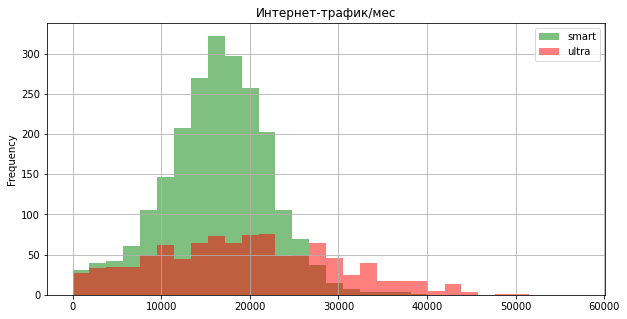

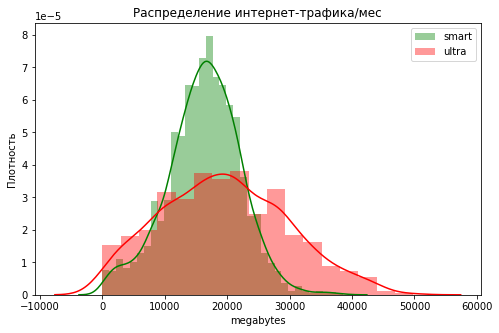

,smart,ultra
count,2.229000e+03,9.850000e+02
mean,1.622919e+04,1.948690e+04
std,5.877577e+03,1.009632e+04
min,0.000000e+00,0.000000e+00
25%,1.265800e+04,1.178500e+04
50%,1.653100e+04,1.932400e+04
75%,2.006800e+04,2.686300e+04
max,3.861000e+04,4.978900e+04
dispersion,3.454591e+07,1.019356e+08


In [41]:
hist_display(report, 'megabytes', 'Интернет-трафик/мес')
distplot_display(report, 'megabytes', 'Распределение интернет-трафика/мес')

* В среднем пользователи Ultra ежемесячно потребляют больше трафика, чем пользователи Smart (19.03 Гб против 15.85 Гб).
* Графики распределения для обоих тарифных планов тяготеют к нормальному. Для Ultra график шире, соответственно, и разброс значений больше. Дисперсия для Ultra почти в 3 раза больше, чем для Smart.

## 4.5. Выручка.

Посмотрим на частотную гистограмму и распределение ежемесячной выручки для каждого тарифного плана.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


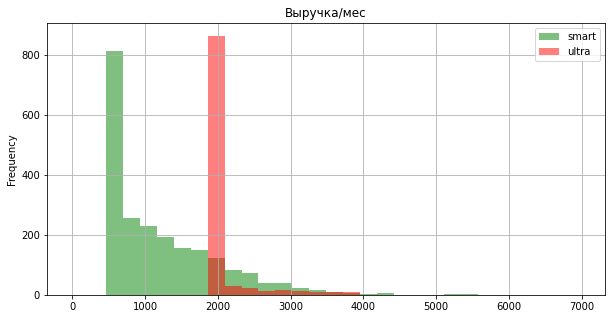

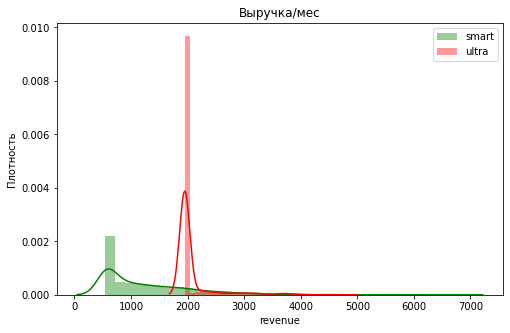

,smart,ultra
count,2229.000000,985.000000
mean,1233.349412,2060.530000
std,787.688121,356.305056
min,550.000000,1950.000000
25%,550.000000,1950.000000
50%,959.900000,1950.000000
75%,1668.120000,1950.000000
max,6711.020000,4743.310000
dispersion,620452.576055,126953.293107


In [42]:
hist_display(report, 'revenue', 'Выручка/мес')
distplot_display(report, 'revenue', 'Выручка/мес')

* Видим пики - это случаи, когда пользователи не превысили установленные лимиты минут/sms/трафика и заплатили только абонентскую плату.
* В среднем пользователи Smart платят меньше, чем пользователи Ultra (1233 против 2060).
* Судя по графику и квартилям, клиенты, подключенные к Smart, намного чаще превышают лимиты, чем клиенты Ultra, поэтому и средняя выручка с них более, чем в 2 раза превышает абонентскую плату по тарифу.

## **Исследовательский анализ данных. Выводы**
Меньше трети попавших в нашу выборку клиентов пользуются тарифом Ultra, остальным подключен Smart. При этом более 40% выручки пришлось на пользователей Ultra.

Но и потребление у пользователей Ultra в среднем выше, чем у пользователей Smart:

* Среднее количество звонков/мес пользователей Ultra больше, чем у пользователей Smart (59 против 47).
* Пользователи Ultra ежемесячно в среднем дольше говорят по телефону, чем пользователи Smart (527 против 418 минут).
* Пользователи тарифа Ultra в среднем отправляют больше sms в месяц, чем пользователи тарифа Smart (49 против 33).
* В среднем пользователи Ultra ежемесячно потребляют больше трафика, чем пользователи Smart (19.03 Гб против 15.85 Гб).
Дисперсии параметров потребления по тарифу Ultra больше, чем по тарифу Smart. Т.е. разброс значений выше среди пользователей Ultra - это также видно и на графиках.

Медианы параметров потребления по обоим тарифным планам примерно совпадают со средними значениями, что свидетельствует об отсутствии большого количества выбросов в нашей выборке.

В среднем пользователи Smart платят меньше, чем пользователи Ultra (1233 против 2060). При этом, судя по частотной гистограмме и квартилям по выручке, клиенты, подключенные к Smart, превышают лимиты намного чаще, чем клиенты Ultra, поэтому и средняя выручка с них более, чем в 2 раза превышает абонентскую плату по тарифу.

# 5. Проверка гипотез 

## 5.1. Средняя выручка пользователей тарифов Ultra и Smart различается


Предположим, что средняя выручка пользователей Ultra и Smart равны между собой - это наша нулевая гипотеза H0.

Проверим нулевую гипотезу о равенстве средних значений двух выборок:

In [43]:
rev_smart = report.query('tariff == "smart"')['revenue'].values
rev_ultra = report.query('tariff == "ultra"')['revenue'].values

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(rev_smart, rev_ultra) 

print('p-значение:', results.pvalue)
 
if results.pvalue<alpha:
  print("Отвергаем нулевую гипотезу")
else:
  print("Не получилось отвергнуть нулевую гипотезу")



p-значение: 1.1725472632487766e-190
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что средние значения наших выборок не равны. И вероятность того, что такой результат мы получили случайно ничтожно мала.

Вероятно, что выручка пользователей тарифов Ultra и Smart различается. Обратного мы доказать не смогли.

## 5.2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Предположим, что выручка пользователей из Москвы и из других регионов равны между собой - это наша нулевая гипотеза H0.

Проверим нулевую гипотезу о равенстве средних значений двух выборок:

In [44]:
rev_moscow = report.query('city == "Москва"')['revenue'].values
rev_other = report.query('city != "Москва"')['revenue'].values

alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(rev_moscow, rev_other)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4744327296711197
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, с вероятностью в 47% такое или большее различие можно получить случайно. Это, разумеется, слишком большая вероятность, чтобы делать вывод о значимом различии средних выручек.

# 6. Общий вывод 

In [45]:
fr = user_report.pivot_table(index='tariff', values=['calls_duration', 'mess_count', 'traffic', 'revenue'], aggfunc=['mean']).reset_index()
fr.columns = ['tariff','calls_duration','mess_count','revenue','traffic']
fr = fr [['tariff','revenue', 'calls_duration','mess_count','traffic']]
display(fr)

,tariff,revenue,calls_duration,mess_count,traffic
0,smart,7854.673829,2661.648571,212.608571,103356.745714
1,ultra,13713.662500,3504.891892,328.533784,129693.229730


Мы проанализировали все показатели активности пользователей обоих тарифных планов и увидели, что в среднем клиенты, подключенные к "Смарт", потребляют меньше ресурсов (звонки/sms/трафик), чем клиенты, подключенные к "Ультра".

При этом пользователи "Смарт" и платят в среднем меньше, чем пользователи "Ультра", хоть и чаще превышают лимиты, установленные тарифом.

Пропорции потребления и выручки по разным тарифным планам однозначно свидетельствуют о более высокой прибыльности тарифа "Ультра" для компании. Причём, во всех регионах, включая Москву.